# Library

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers,Input
from keras.models import  Sequential
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1,L1L2

In [14]:
xTrain=np.load("../Data/julyData/trainData.npy")
yTrain=np.load("../Data/julyData/trainTarget.npy")
xTest=np.load('../Data/julyData/testData.npy')
yTest=np.load("../Data/julyData/testTarget.npy")

X_train=np.reshape(xTrain,(xTrain.shape[0],40,50,1))
X_test=np.reshape(xTest,(xTest.shape[0],40,50,1))


# yTrain=np.reshape(yTrain,(yTrain.shape[0]))
# yTest=np.reshape(yTest,(yTest.shape[0]))
# xTrain=np.reshape(xTrain,(xTrain.shape[0],20,25,1))
# xTest=np.reshape(xTest,(xTest.shape[0],20,25,1))
print(X_train.shape)

(1600, 40, 50, 1)


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(xTrain)
X_test = sc.transform(xTest)
pca = PCA(n_components = 200)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
del xTest,xTrain
X_train=np.reshape(X_train,(X_train.shape[0],200,1))
X_test=np.reshape(X_test,(X_test.shape[0],200,1))
print("X shape: {}".format(X_train.shape))

X shape: (1600, 200, 1)


# CRNN

In [16]:
def arch():
    model=Sequential()
    model.add(layers.Conv1D(16,kernel_size=3, padding='valid', strides=1, input_shape=(200,1),activation='relu',kernel_regularizer=L1L2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(3,2))
    model.add(layers.Conv1D(16,kernel_size=3, padding='valid', strides=1,activation='relu',kernel_regularizer=L1L2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(3,2))
    model.add(layers.Conv1D(16,kernel_size=3, padding='valid', strides=1,activation='relu',kernel_regularizer=L1L2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(3,2))
    model.add(layers.CuDNNLSTM(units=128,return_sequences=False))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dropout(0.65))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.65))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dropout(0.65))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dropout(0.65))
    model.add(layers.Dense(4,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    return model



def arch2():
    model=Sequential()
    model.add(layers.Conv2D(16, (3,3), padding='valid', strides=2, input_shape=(40,50,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((3,3), padding='valid', strides=2))
    model.add(layers.Conv2D(16, (3,3), padding='valid', strides=2, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((20,16)))
    model.add(layers.CuDNNLSTM(units=16,return_sequences=False,kernel_regularizer=L1L2(0.0001)))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
# arch2().summary()

In [17]:
model=arch()
model.summary()
opt=Adam( learning_rate=0.001)
model.compile(loss=binary_crossentropy, optimizer=opt, metrics=['accuracy'])
model_path="../Model/RNN_new/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 16)           64        
                                                                 
 batch_normalization_10 (Bat  (None, 198, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 16)            784       
                                                                 
 batch_normalization_11 (Bat  (None, 96, 16)           64        
 chNormalization)                                                
                                                      

In [18]:
with tf.device("/gpu:0"):
    H=model.fit(X_train,yTrain,
            validation_data=(X_test, yTest),
            epochs=200,batch_size=32,
            callbacks=callbacks_list,
            verbose=1)

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.5075
Epoch 1: val_accuracy improved from -inf to 0.50250, saving model to ../Model/RNN_new/01-0.5025.h5
50/50 [==============================] - 3s 28ms/step - loss: 0.7240 - accuracy: 0.5075 - val_loss: 0.7129 - val_accuracy: 0.5025
Epoch 2/200
47/50 [===========================>..] - ETA: 0s - loss: 0.7201 - accuracy: 0.4914
Epoch 2: val_accuracy did not improve from 0.50250
50/50 [==============================] - 1s 16ms/step - loss: 0.7201 - accuracy: 0.4919 - val_loss: 0.7129 - val_accuracy: 0.5025
Epoch 3/200
47/50 [===========================>..] - ETA: 0s - loss: 0.7146 - accuracy: 0.5319
Epoch 3: val_accuracy did not improve from 0.50250
50/50 [==============================] - 1s 15ms/step - loss: 0.7148 - accuracy: 0.5319 - val_loss: 0.7128 - val_accuracy: 0.5025
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.5094
Epoch 4: val_accuracy did not

KeyboardInterrupt: 

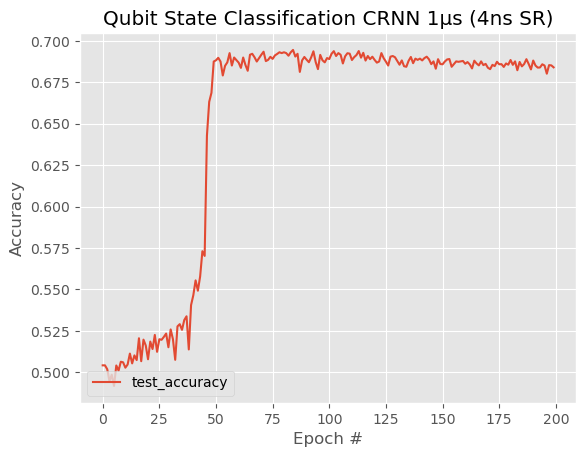

In [9]:
N = 200
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Qubit State Classification CRNN 1μs (4ns SR)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")